In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import copy
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# for creating validation set
from sklearn.model_selection import train_test_split

%matplotlib notebook
%matplotlib notebook
# %matplotlib inline
# %matplotlib qt

In [3]:
import sys

sys.path.append('/media/rich/Home_Linux_partition/github_repos/')

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, decomposition
from GCaMP_ROI_classifier.old_stuff import util, models, training_simCLR, augmentation

## Import training data

In [4]:
import pickle

with open('/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data/all_stat_files_20211022.pkl', 'rb') as file:
    statFiles_scraped = pickle.load(file)

In [5]:
keys_toDelete = [
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\16x_analysis20200514\\Suite2p and MC for denoised movie\\suite2p\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20201102\\suite2p_accidentally_run_on_everything\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attemp 2 _tau 1_5\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 1 _tau 2\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 3 _tau 1\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\AAV\\oldBMIrampExp_20191112_mouse1013A\\ROI extraction\\suite2p\\plane0\\stat.npy',
]
for key in keys_toDelete:
    del statFiles_scraped[key]

In [6]:
sf_list = util.convert_multiple_stat_files(statFiles_dict=statFiles_scraped, out_height_width=[36,36], max_footprint_width=901, plot_pref=False)

images_all = np.concatenate(sf_list, axis=0)

images_all.shape

(217802, 36, 36)

In [7]:
images_all_norm = (images_all / np.sum(images_all, axis=(1,2), keepdims=True)) * 255

In [8]:
# create validation set
# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(images_all_norm, np.arange(images_all.shape[0]), test_size = 0.15)
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((185131, 36, 36), (185131,)), ((32671, 36, 36), (32671,)))

<IPython.core.display.Javascript object>


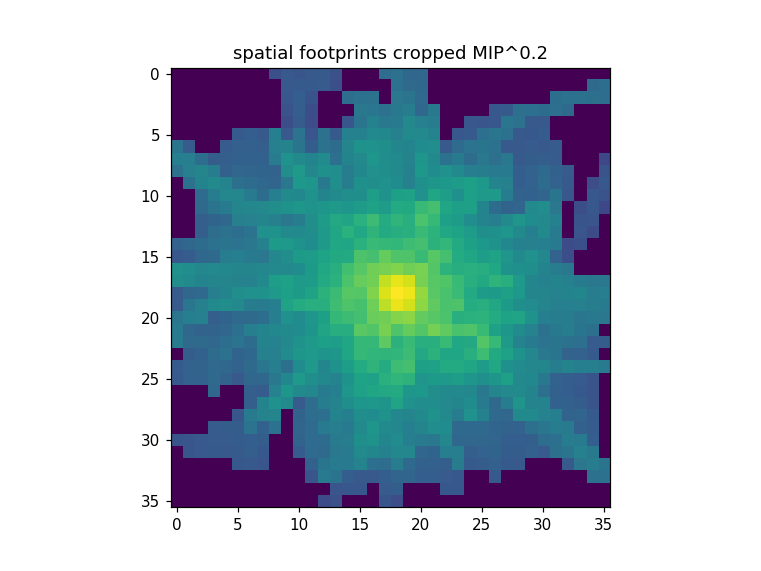

<IPython.core.display.Javascript object>


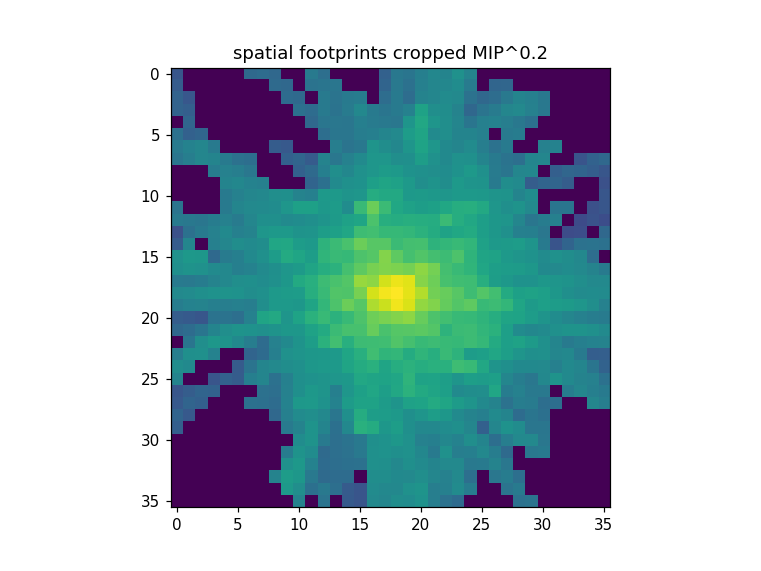

concatenated images shape: (9715, 36, 36)


<IPython.core.display.Javascript object>


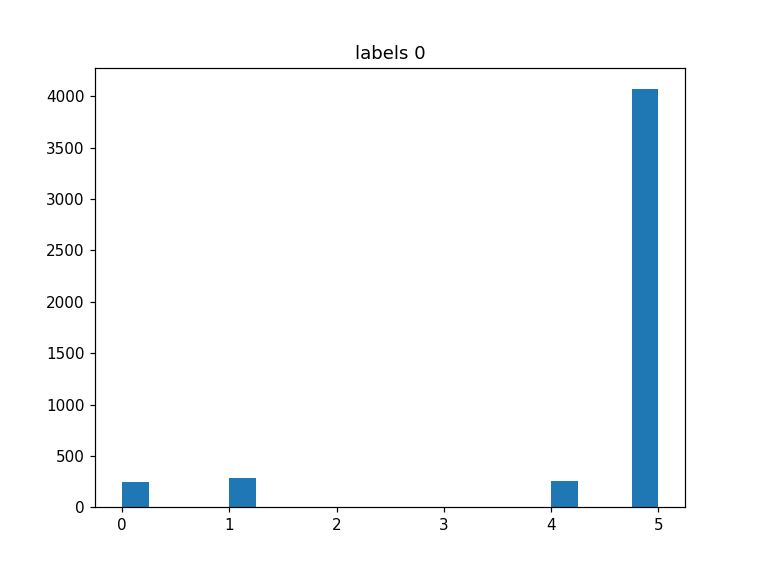

<IPython.core.display.Javascript object>


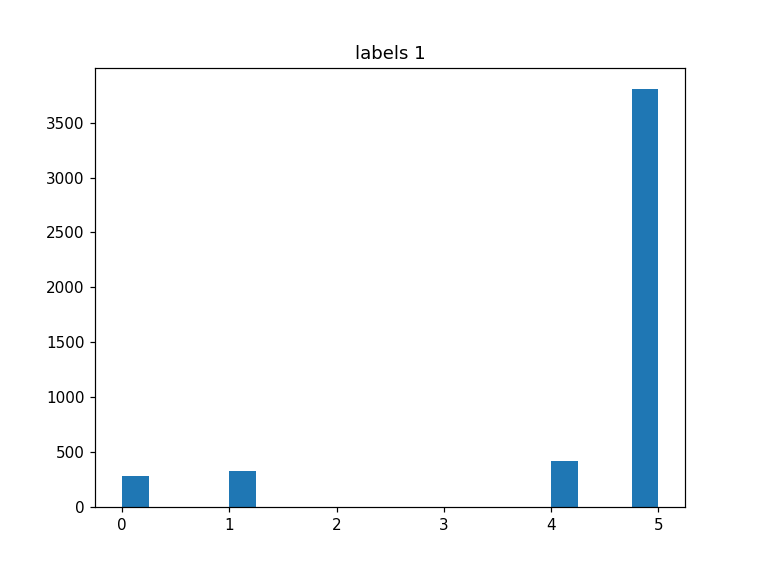

In [9]:
dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

statFile_import_kwargs = {'out_height_width': [36,36],
                          'max_footprint_width': 241,
                          'plot_pref':True}

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                        fileNames_statFiles=fileNames_statFiles,
                                        out_height_width=[36,36],
                                        max_footprint_width=241,
                                        plot_pref=True)
images_labeled = np.concatenate(sf_all, axis=0) *255
print(f'concatenated images shape: {images_labeled.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

## Balance classes of inputs

## Define augmentation pipeline

In [10]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
#     torchvision.transforms.RandomHorizontalFlip(p=0.5),
    
#     torchvision.transforms.GaussianBlur(kernel_size=5,
#                                         sigma=(0.0001, 0.5)),
    
#     torchvision.transforms.RandomPerspective(distortion_scale=0.4, 
#                                              p=0.5, 
#                                              interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                              fill=0),
#     torchvision.transforms.RandomAffine(
#                                         degrees=(-180,180),
#                                         translate=(0.3, 0.3),
#                                         scale=(0.7, 1.7), 
#                                         shear=(-30, 30, -30, 30), 
#                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                         fill=0, 
#                                         fillcolor=None, 
#                                         resample=None),
    
#     augmentation.AddPoissonNoise(   level_bounds=(0,0.7),
#                                     prob=1),

#     augmentation.AddGaussianNoise(  mean=0, 
#                                     std=0.4,
#                                     prob=1),
)
scripted_transforms = torch.jit.script(transforms)
# scripted_transforms = transforms


dataset_train = util.dataset_simCLR(torch.tensor(X_train), 
                                    y_train, 
                                    n_transforms=2, 
                                    transform=scripted_transforms,
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64 )

dataloader_train = torch.utils.data.DataLoader( dataset_train,
                                                batch_size=1024,
            #                                     sampler=sampler,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=False,
                                                num_workers=32,
                                                prefetch_factor=3,
                                                persistent_workers=True,
                                                )

# dataset_val = util.dataset_simCLR(torch.tensor(X_val), 
#                                     y_val, 
#                                     n_transforms=2, 
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64 )

# dataloader_val = torch.utils.data.DataLoader(   dataset_val,
#                                                 batch_size=128,
#             #                                     sampler=sampler,
#                                                 shuffle=True,
#                                                 drop_last=True,
#                                                 pin_memory=True,
#                                                 num_workers=0,
#                                                 )

## Train

In [11]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [12]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=128)
model.train()
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0005,
#                                                    gamma=1,
                                                  )
val_obj = training_simCLR.validation_Obj(   X_val,
                                            y_val,
                                            model,
                                            criterion,
                                            DEVICE=DEVICE,
                                            dtype_X=torch.float32,
                                            dtype_y=torch.int64)

model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses_train, losses_val, val_accs = [], [np.nan], []

In [13]:
n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    training_simCLR.epoch_step( dataloader_train, 
                                model, 
                                optimizer, 
                                criterion, 
                                scheduler=scheduler, 
                                temperature=0.5,
                                loss_rolling_train=losses_train, 
                                device=DEVICE, 
                                do_validation=False,
                                validation_Object=val_obj,
                                loss_rolling_val=losses_val,
                                verbose=2,
                                verbose_update_period=10,
                               )

epoch: 0
Iter: 0/180, loss_train: 7.4691, loss_val: nan, lr: 0.0009995
Iter: 10/180, loss_train: 6.5399, loss_val: nan, lr: 0.00099451
Iter: 20/180, loss_train: 6.1352, loss_val: nan, lr: 0.00098955
Iter: 30/180, loss_train: 6.0338, loss_val: nan, lr: 0.00098462
Iter: 40/180, loss_train: 5.9491, loss_val: nan, lr: 0.0009797
Iter: 50/180, loss_train: 5.8904, loss_val: nan, lr: 0.00097482
Iter: 60/180, loss_train: 5.8592, loss_val: nan, lr: 0.00096995
Iter: 70/180, loss_train: 5.843, loss_val: nan, lr: 0.00096511
Iter: 80/180, loss_train: 5.8336, loss_val: nan, lr: 0.0009603
Iter: 90/180, loss_train: 5.8016, loss_val: nan, lr: 0.00095551
Iter: 100/180, loss_train: 5.8395, loss_val: nan, lr: 0.00095074
Iter: 110/180, loss_train: 5.7992, loss_val: nan, lr: 0.000946
Iter: 120/180, loss_train: 5.8208, loss_val: nan, lr: 0.00094128
Iter: 130/180, loss_train: 5.7821, loss_val: nan, lr: 0.00093658
Iter: 140/180, loss_train: 5.7782, loss_val: nan, lr: 0.00093191
Iter: 150/180, loss_train: 5.7776

Iter: 10/180, loss_train: 5.7056, loss_val: nan, lr: 0.00052959
Iter: 20/180, loss_train: 5.7109, loss_val: nan, lr: 0.00052694
Iter: 30/180, loss_train: 5.7096, loss_val: nan, lr: 0.00052432
Iter: 40/180, loss_train: 5.7149, loss_val: nan, lr: 0.0005217
Iter: 50/180, loss_train: 5.7157, loss_val: nan, lr: 0.0005191
Iter: 60/180, loss_train: 5.7167, loss_val: nan, lr: 0.00051651
Iter: 70/180, loss_train: 5.7113, loss_val: nan, lr: 0.00051393
Iter: 80/180, loss_train: 5.7079, loss_val: nan, lr: 0.00051137
Iter: 90/180, loss_train: 5.706, loss_val: nan, lr: 0.00050882
Iter: 100/180, loss_train: 5.7115, loss_val: nan, lr: 0.00050628
Iter: 110/180, loss_train: 5.7017, loss_val: nan, lr: 0.00050375
Iter: 120/180, loss_train: 5.7344, loss_val: nan, lr: 0.00050124
Iter: 130/180, loss_train: 5.7172, loss_val: nan, lr: 0.00049874
Iter: 140/180, loss_train: 5.7097, loss_val: nan, lr: 0.00049625
Iter: 150/180, loss_train: 5.7044, loss_val: nan, lr: 0.00049377
Iter: 160/180, loss_train: 5.7119, lo

Iter: 20/180, loss_train: 5.6917, loss_val: nan, lr: 0.0002806
Iter: 30/180, loss_train: 5.6956, loss_val: nan, lr: 0.0002792
Iter: 40/180, loss_train: 5.6976, loss_val: nan, lr: 0.00027781
Iter: 50/180, loss_train: 5.698, loss_val: nan, lr: 0.00027642
Iter: 60/180, loss_train: 5.7023, loss_val: nan, lr: 0.00027504
Iter: 70/180, loss_train: 5.712, loss_val: nan, lr: 0.00027367
Iter: 80/180, loss_train: 5.6969, loss_val: nan, lr: 0.00027231
Iter: 90/180, loss_train: 5.6906, loss_val: nan, lr: 0.00027095
Iter: 100/180, loss_train: 5.6956, loss_val: nan, lr: 0.0002696
Iter: 110/180, loss_train: 5.6938, loss_val: nan, lr: 0.00026825
Iter: 120/180, loss_train: 5.6975, loss_val: nan, lr: 0.00026691
Iter: 130/180, loss_train: 5.693, loss_val: nan, lr: 0.00026558
Iter: 140/180, loss_train: 5.7002, loss_val: nan, lr: 0.00026426
Iter: 150/180, loss_train: 5.6945, loss_val: nan, lr: 0.00026294
Iter: 160/180, loss_train: 5.7048, loss_val: nan, lr: 0.00026163
Iter: 170/180, loss_train: 5.6969, loss

Iter: 30/180, loss_train: 5.6879, loss_val: nan, lr: 0.00014868
Iter: 40/180, loss_train: 5.6895, loss_val: nan, lr: 0.00014794
Iter: 50/180, loss_train: 5.6971, loss_val: nan, lr: 0.0001472
Iter: 60/180, loss_train: 5.6903, loss_val: nan, lr: 0.00014646
Iter: 70/180, loss_train: 5.6939, loss_val: nan, lr: 0.00014573
Iter: 80/180, loss_train: 5.6884, loss_val: nan, lr: 0.00014501
Iter: 90/180, loss_train: 5.6905, loss_val: nan, lr: 0.00014428
Iter: 100/180, loss_train: 5.6907, loss_val: nan, lr: 0.00014356
Iter: 110/180, loss_train: 5.6902, loss_val: nan, lr: 0.00014285
Iter: 120/180, loss_train: 5.691, loss_val: nan, lr: 0.00014213
Iter: 130/180, loss_train: 5.6927, loss_val: nan, lr: 0.00014142
Iter: 140/180, loss_train: 5.6904, loss_val: nan, lr: 0.00014072
Iter: 150/180, loss_train: 5.6951, loss_val: nan, lr: 0.00014002
Iter: 160/180, loss_train: 5.6907, loss_val: nan, lr: 0.00013932
Iter: 170/180, loss_train: 5.6951, loss_val: nan, lr: 0.00013862
epoch: 22
Iter: 0/180, loss_train:

Iter: 40/180, loss_train: 5.6885, loss_val: nan, lr: 7.8777e-05
Iter: 50/180, loss_train: 5.6905, loss_val: nan, lr: 7.8384e-05
Iter: 60/180, loss_train: 5.6862, loss_val: nan, lr: 7.7993e-05
Iter: 70/180, loss_train: 5.6857, loss_val: nan, lr: 7.7604e-05
Iter: 80/180, loss_train: 5.6848, loss_val: nan, lr: 7.7217e-05
Iter: 90/180, loss_train: 5.6835, loss_val: nan, lr: 7.6831e-05
Iter: 100/180, loss_train: 5.6853, loss_val: nan, lr: 7.6448e-05
Iter: 110/180, loss_train: 5.6848, loss_val: nan, lr: 7.6067e-05
Iter: 120/180, loss_train: 5.6845, loss_val: nan, lr: 7.5687e-05
Iter: 130/180, loss_train: 5.6853, loss_val: nan, lr: 7.531e-05
Iter: 140/180, loss_train: 5.6842, loss_val: nan, lr: 7.4934e-05
Iter: 150/180, loss_train: 5.687, loss_val: nan, lr: 7.456e-05
Iter: 160/180, loss_train: 5.6833, loss_val: nan, lr: 7.4188e-05
Iter: 170/180, loss_train: 5.6839, loss_val: nan, lr: 7.3818e-05
epoch: 29
Iter: 0/180, loss_train: 5.6839, loss_val: nan, lr: 7.345e-05
Iter: 10/180, loss_train: 5

Iter: 50/180, loss_train: 5.6839, loss_val: nan, lr: 4.174e-05
Iter: 60/180, loss_train: 5.6837, loss_val: nan, lr: 4.1532e-05
Iter: 70/180, loss_train: 5.6831, loss_val: nan, lr: 4.1325e-05
Iter: 80/180, loss_train: 5.6806, loss_val: nan, lr: 4.1118e-05
Iter: 90/180, loss_train: 5.6834, loss_val: nan, lr: 4.0913e-05
Iter: 100/180, loss_train: 5.6838, loss_val: nan, lr: 4.0709e-05
Iter: 110/180, loss_train: 5.6831, loss_val: nan, lr: 4.0506e-05
Iter: 120/180, loss_train: 5.683, loss_val: nan, lr: 4.0304e-05
Iter: 130/180, loss_train: 5.6844, loss_val: nan, lr: 4.0103e-05
Iter: 140/180, loss_train: 5.6844, loss_val: nan, lr: 3.9903e-05
Iter: 150/180, loss_train: 5.6847, loss_val: nan, lr: 3.9704e-05
Iter: 160/180, loss_train: 5.6832, loss_val: nan, lr: 3.9506e-05
Iter: 170/180, loss_train: 5.681, loss_val: nan, lr: 3.9309e-05
epoch: 36
Iter: 0/180, loss_train: 5.682, loss_val: nan, lr: 3.9113e-05
Iter: 10/180, loss_train: 5.6821, loss_val: nan, lr: 3.8917e-05
Iter: 20/180, loss_train: 5

Iter: 60/180, loss_train: 5.6827, loss_val: nan, lr: 2.2116e-05
Iter: 70/180, loss_train: 5.6798, loss_val: nan, lr: 2.2006e-05
Iter: 80/180, loss_train: 5.6797, loss_val: nan, lr: 2.1896e-05
Iter: 90/180, loss_train: 5.6808, loss_val: nan, lr: 2.1787e-05
Iter: 100/180, loss_train: 5.6807, loss_val: nan, lr: 2.1678e-05
Iter: 110/180, loss_train: 5.6809, loss_val: nan, lr: 2.157e-05
Iter: 120/180, loss_train: 5.6793, loss_val: nan, lr: 2.1462e-05
Iter: 130/180, loss_train: 5.6836, loss_val: nan, lr: 2.1355e-05
Iter: 140/180, loss_train: 5.6804, loss_val: nan, lr: 2.1249e-05
Iter: 150/180, loss_train: 5.6808, loss_val: nan, lr: 2.1143e-05
Iter: 160/180, loss_train: 5.683, loss_val: nan, lr: 2.1037e-05
Iter: 170/180, loss_train: 5.6803, loss_val: nan, lr: 2.0932e-05
epoch: 43
Iter: 0/180, loss_train: 5.6808, loss_val: nan, lr: 2.0828e-05
Iter: 10/180, loss_train: 5.6798, loss_val: nan, lr: 2.0724e-05
Iter: 20/180, loss_train: 5.6807, loss_val: nan, lr: 2.062e-05
Iter: 30/180, loss_train: 

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


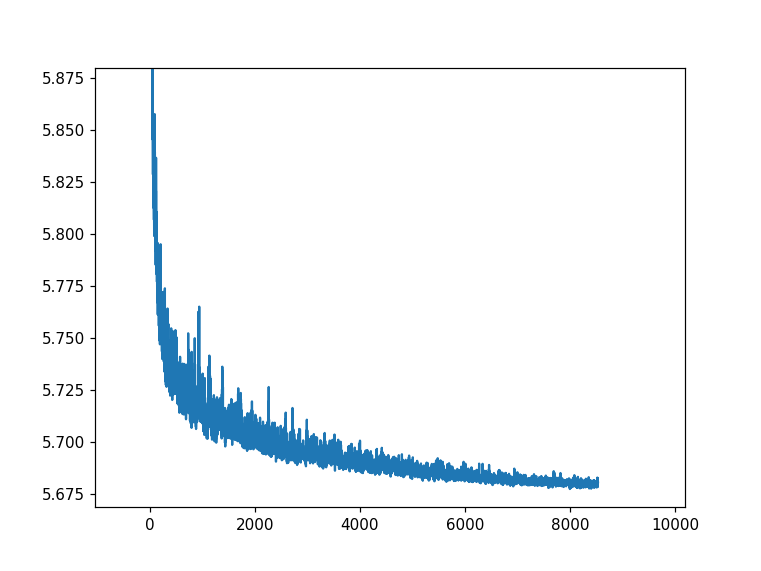

In [14]:
plt.figure()
plt.plot(losses_train)

## Check embeddings

In [15]:
torch.cuda.empty_cache()

In [16]:
features = model(torch.tensor(images_labeled, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_val, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()

In [17]:
_, features_embedded, _, _ = decomposition.torch_pca(features, device=DEVICE, return_cpu=True)

In [19]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, 
                     perplexity=90.0, 
                     early_exaggeration=12.0, 
                     learning_rate=200, 
                     n_iter=1000, 
                     n_iter_without_progress=300, 
                     min_grad_norm=1e-07, 
                     metric='euclidean', 
                     init='pca', 
                     verbose=0, 
                     random_state=None, 
                     method='barnes_hut', 
                     angle=0.5, 
                     n_jobs=-1, 
                     square_distances='legacy'
                    )
features_embedded = tsne.fit_transform(features.cpu())

<IPython.core.display.Javascript object>


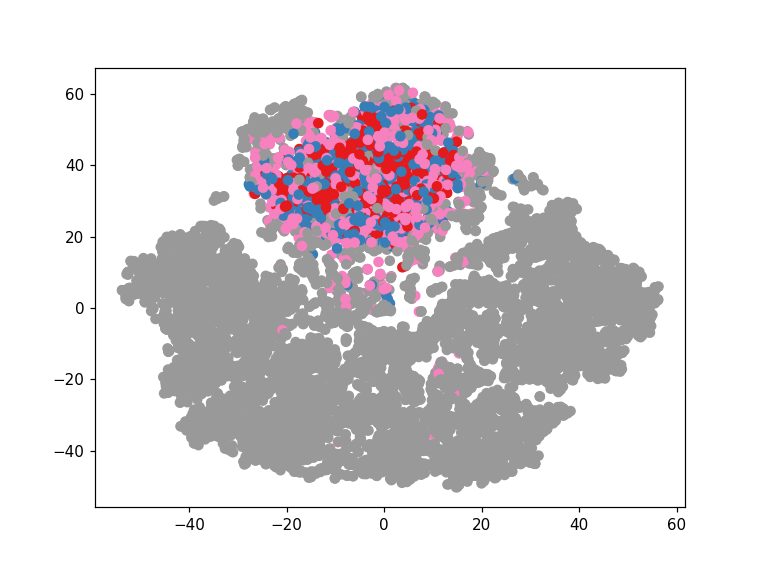

In [20]:
import matplotlib as mpl

mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)
mpl.rcParams['image.cmap'] = 'viridis'


## Check filters

In [24]:
list(model.state_dict().keys())

['cnn_layers.0.weight',
 'cnn_layers.0.bias',
 'cnn_layers.2.weight',
 'cnn_layers.2.bias',
 'cnn_layers.5.weight',
 'cnn_layers.5.bias',
 'cnn_layers.8.weight',
 'cnn_layers.8.bias',
 'linear_layers.0.weight',
 'linear_layers.0.bias',
 'linear_layers.2.weight',
 'linear_layers.2.bias']

<IPython.core.display.Javascript object>


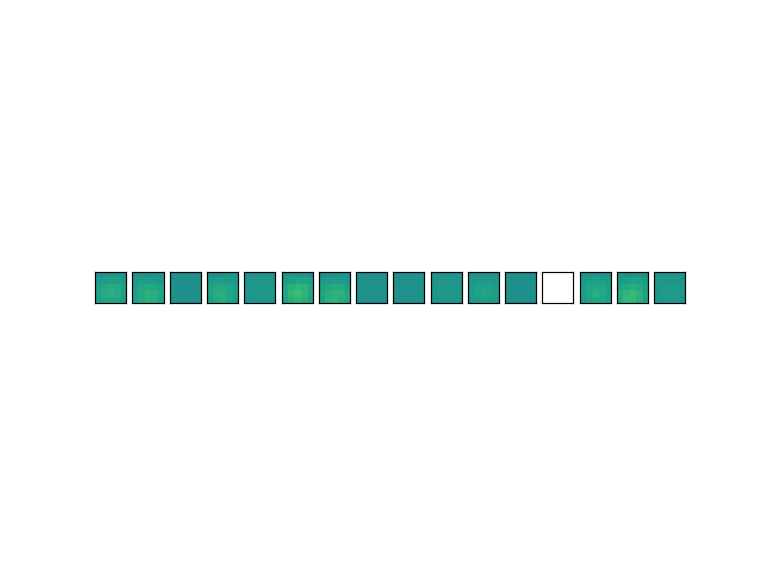

<IPython.core.display.Javascript object>


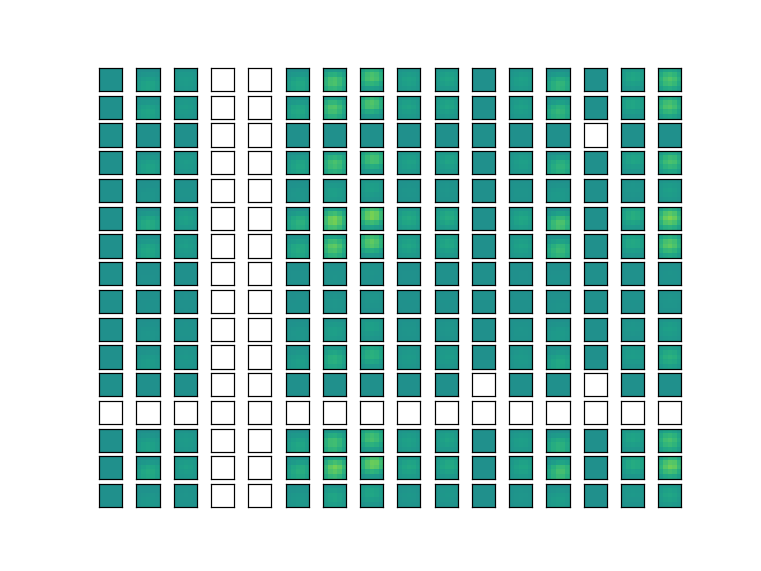

<IPython.core.display.Javascript object>


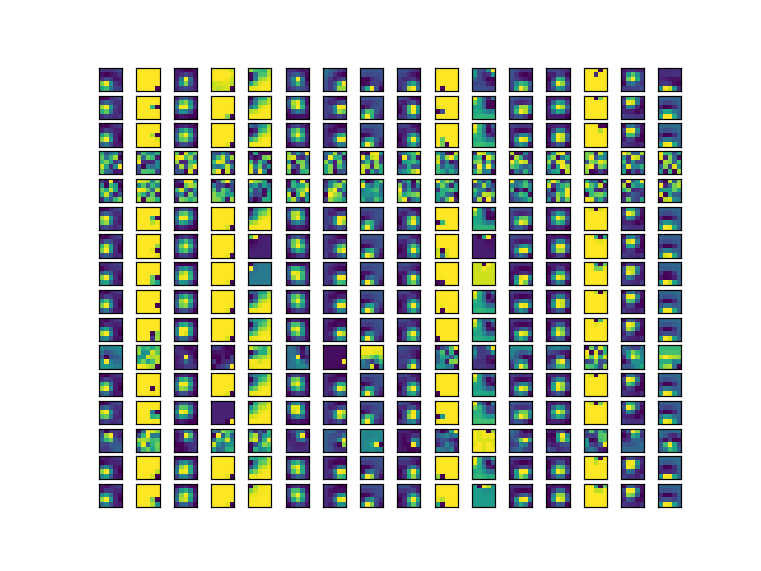

<IPython.core.display.Javascript object>


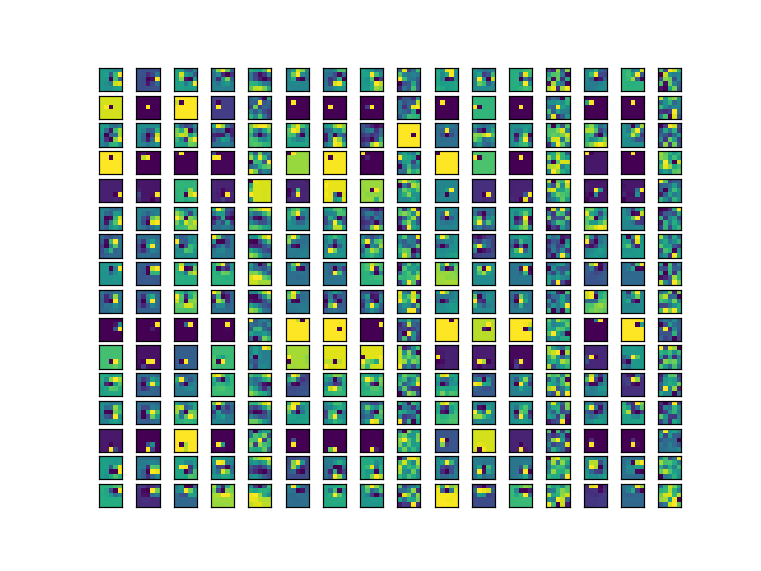

In [21]:
layer_1 = model.state_dict()['cnn_layers.0.weight'].cpu()
layer_2 = model.state_dict()['cnn_layers.2.weight'].cpu()
layer_3 = model.state_dict()['cnn_layers.5.weight'].cpu()
layer_4 = model.state_dict()['cnn_layers.8.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(layer_2.shape[1]):
    for jj in range(layer_2.shape[0]):
        plt.subplot2grid((layer_2.shape[1],layer_2.shape[0]),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [84]:
torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
model = Net()
model.load_state_dict(torch.load('test_save.pth'))
model.eval()